## Introduction

The last decade witnessed a major shift in the food and beverage industry in terms of consumer demand for healthy food. Unlike earlier generations, who are most likely to be never found in the gym, this generation takes health and lifestyle to be their priority. People track down their daily steps and activity through their gadgets, and take deep notes on what they are eating. The recent shift towards healthy food trends made us curious enough to research on what the increase in consumer demand is and how restaurateurs are catering to the trend. 

My business idea is to set up restaurants servings healthy food in the New York city to bank on this healthy food trend. Appropriate locations would be near a gym, yoga studio or any kind of health/ fitness related centers. People who go to gyms and engage in outdoor activities to stay fit follow a strict diet which consists of healthy foods like salads, protein shakes and similar low carbohydrate foods. Needless to say opening a restaurant serving such cuisine would be highly appreciated by the fitness community 

## Data that will be used to solve the problem and the source of the data

Being the most populated city in the United States, New York city is one of the most developed cities in the world. The city consists of several boroughs. The city not only has historical tourist locations but also modern attractions and amenities.

I will be conducting my analysis on the locational data obtained from FourSquare. The data would help me identify the neighborhoods in the New York city where fitness centers are concentrated. This data would help me evaluate the appropriate location for setting up my restaurant/s.

This would also help me compare several locations and conduct various market and feasibility studies which can be then leveraged in helping the business gain a headstart.

## Running the codes/ programme to conduct analysis

### Importing required libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    scipy-1.4.1                |   py36h921218d_0        18.9 MB  conda-forge
    lib

### Downloading the data

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


### Loading the dataset

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

### Storing the data in Dataframe

In [4]:
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### Get Latitiude and Longitude of New York City

In [5]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


### Create a map of New York with neighborhoods superimposed on top

In [6]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Define Foursquare Credentials and Version

In [7]:
CLIENT_ID = 'KZ524DI0U1R2WT4XXDN1Q5NAJ3WV2UC1MBRPJF2YR30SORF0' # your Foursquare ID
CLIENT_SECRET = 'OYM2GF4CQL1GAOMAKKIIQCLWPRHF2WBF0XQWM2A5RZVES0TX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KZ524DI0U1R2WT4XXDN1Q5NAJ3WV2UC1MBRPJF2YR30SORF0
CLIENT_SECRET:OYM2GF4CQL1GAOMAKKIIQCLWPRHF2WBF0XQWM2A5RZVES0TX


### Creating a function to explore all places around New York

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=50):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&r0adius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Get venues near the aforementioned Neighbourhood

In [12]:
newyork_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [13]:
newyork_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Ripe Kitchen & Bar,40.898152,-73.838875,Caribbean Restaurant
2,Wakefield,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
3,Wakefield,40.894705,-73.847201,Jimbo's,40.891740,-73.858226,Burger Joint
4,Wakefield,40.894705,-73.847201,Kingston Tropical Bakery,40.888568,-73.859885,Bakery


### Analyze Each Neighborhood

In [14]:
# one hot encoding
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot['Neighborhood'] = newyork_venues['Neighborhood'] 

# setting index to neighborhood
newyork_onehot.set_index('Neighborhood', inplace=True)
newyork_onehot.reset_index(inplace=True)

newyork_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burmese Restaurant,Burrito Place,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern Greek Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing 

### Grouping rows by neighborhood and taking the frequency of occurrence of each category

In [15]:
newyork_fitness = newyork_onehot[['Neighborhood','Boxing Gym','Climbing Gym','Gym','Gym / Fitness Center','Gym Pool','Gymnastics Gym','Pilates Studio','Yoga Studio']]
newyork_grouped = newyork_fitness.groupby('Neighborhood').sum()
newyork_grouped['Total'] =  newyork_grouped.sum (axis = 1)
newyork_grouped.reset_index(inplace=True)
newyork_grouped.head()

,Neighborhood,Boxing Gym,Climbing Gym,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Pilates Studio,Yoga Studio,Total
0,Allerton,0,0,0,0,0,0,0,0,0
1,Annadale,0,0,1,2,0,0,0,0,3
2,Arden Heights,0,0,1,1,0,0,0,0,2
3,Arlington,0,0,0,1,0,0,0,0,1
4,Arrochar,0,0,0,0,0,0,0,0,0


### Extracting top 10 neighborhoods in terms of the number of health or fitness related centres

In [16]:
newyork_sorted = newyork_grouped.sort_values(by='Total', ascending=False).head(10)
newyork_sorted.reset_index(inplace=True)
newyork_sorted.drop(['index'], axis=1, inplace=True)
newyork_sorted

,Neighborhood,Boxing Gym,Climbing Gym,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Pilates Studio,Yoga Studio,Total
0,Vinegar Hill,2,1,2,1,0,0,0,2,8
1,Sutton Place,0,0,3,3,0,0,0,2,8
2,Brooklyn Heights,0,0,2,1,0,0,1,4,8
3,Civic Center,0,0,2,3,0,0,0,2,7
4,Dumbo,2,1,2,0,0,0,0,2,7
5,Melrose,0,0,5,2,0,0,0,0,7
6,Lenox Hill,0,0,3,3,0,0,0,0,6
7,Carnegie Hill,0,0,2,2,0,0,0,2,6
8,Mount Hope,0,0,2,4,0,0,0,0,6
9,Flatiron,0,0,1,3,0,0,0,2,6


### Importing Matplob Library for Visualisation

In [17]:
# using the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.1.1


### Visualising number of places in each neighborhood related to fitness using bar chart

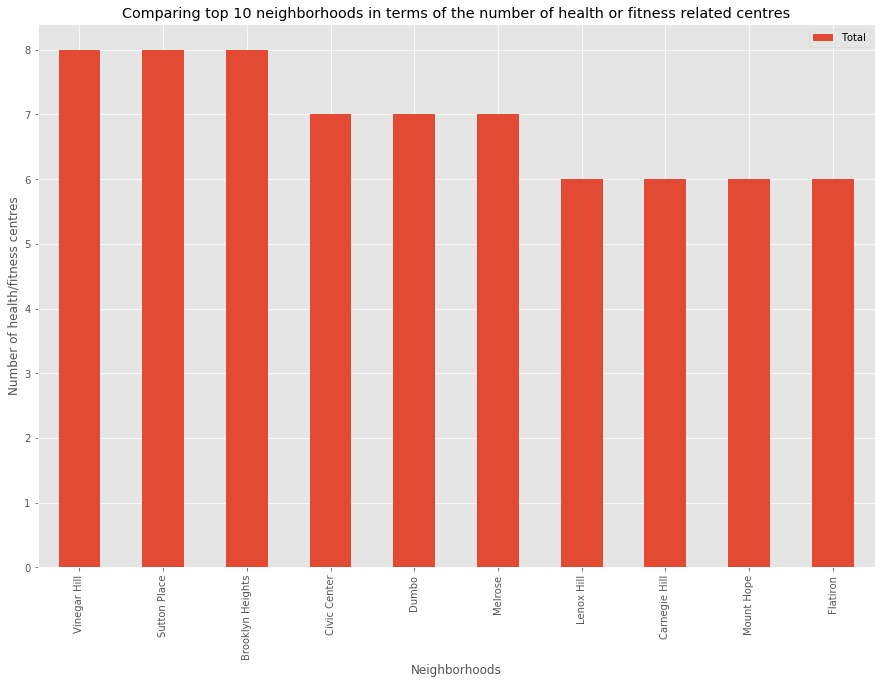

In [18]:
newyork_bar = newyork_sorted[['Neighborhood','Total']]
newyork_bar.plot(kind='bar', figsize=(15, 10))
labels=newyork_bar['Neighborhood'].tolist()
index=[i for i, _ in enumerate(labels)]

plt.xticks(index, labels)
plt.xlabel('Neighborhoods') # add to x-label to the plot
plt.ylabel('Number of health/fitness centres') # add y-label to the plot
plt.title('Comparing top 10 neighborhoods in terms of the number of health or fitness related centres') # add title to the plot

plt.show()

## Methodology Section

I adopted the methodology of visualising the top 10 neighborhoods in terms of the number of health/ fitness related centers in the same. Accordingly I can carry out other qualitative analysis to further rule out neighborhoods out of these narrowed ones.

I decided to use the bar chart to compare the frequency of the centers.

## Result

Top 10 location for further analysis are Vinegar Hill, Sutton Place, Brooklyn Heights, Civic Center, Dumbo, Melrose, Lenox Hill, Carnegie Hill, Mount Hope and Flatiron.

## Recommendations

It can be seen from the bar chart that Vinegar Hill, Sutton Place and Brooklyn Heights have the highest number of fitness/ health related centers each having 8 such places. It is recommended to place further efforts in evaluating these locations and conduct feasibility studies and market research for them.

## Conclusion